In [ ]:
# develop-self-sustained-translation-operator.ipynb
#
# Bryan Daniels
# 2023/11/9
#
# Try to get translation of edge without external input
# (starting with code from develop-translation-operator.ipynb)

In [1]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from toolbox import defaultFigure
defaultFigure.setDefaultParams()

from laplace_network import laplace_network

In [ ]:
# create separate set of neurons that represent the "bump" derivatives of the edge state neurons


In [2]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation = 50 # number of units in each population
J = 2 # constant interaction strength between neighbors

net = laplace_network(Npopulation,J)

In [8]:
# old external input code
# (takes a couple of minutes with Npopulation = 50)

noise_var = 1e-4 # 0.1 # strength of noise (variance added per unit time)
i_final = 5 #(t increases exponentially with i) #100 #20
t_start = 0.1 #1. #0.5 #1.
t_final = t_start + 2**(i_final-1)
delta_t = 0.001 #0.001
input_times = np.arange(t_start,t_final+delta_t,delta_t)[:-1] # don't need an input at the final timepoint
seed = 12345
center = 25

# start at edge state
edge_state = net.find_edge_state(center)

# compute time-varying input that decays in time
# goal: move 1/t per unit of time
translation_input_time_varying = []
edge_state_old = edge_state.copy()
for t in input_times:
    n = center + np.log(t)
    edge_state_new = net.find_edge_state(n)
    translation_input_edge_neurons = (edge_state_new - edge_state_old)/delta_t
    # (for now include input only for edge neurons)
    translation_input = np.concatenate([translation_input_edge_neurons[:Npopulation],
                                        np.zeros(Npopulation)])
    translation_input_time_varying.append(translation_input)
    edge_state_old = edge_state_new.copy()
    
# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final-t_start,
                               noise_var,
                               additional_input=translation_input_time_varying,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states.index = states.index + t_start
rates = np.tanh(states)

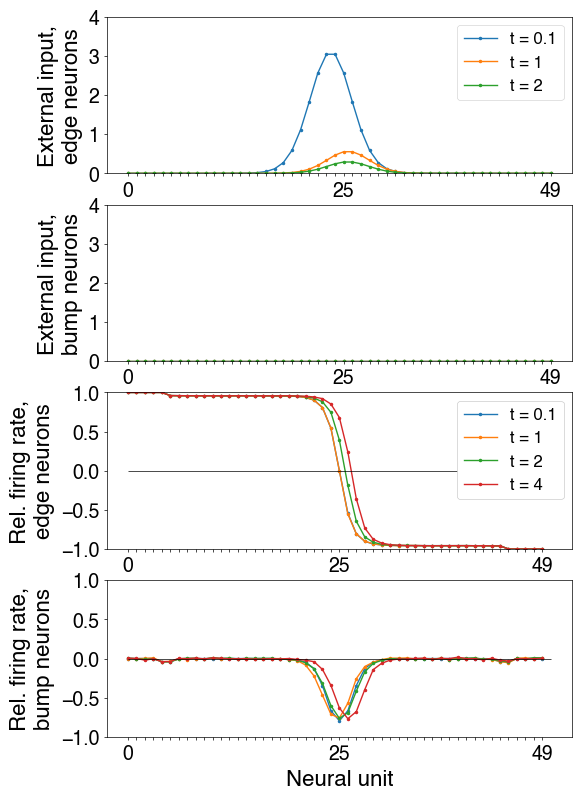

In [11]:
plt.figure(figsize=(6,9))
minInput,maxInput = 0,4
minRate,maxRate = -1,1

# input plot, edge neurons
plt.subplot(4,1,1)
times = [0.1,1,2,4] 
for t in times[:-1]:
    plt.plot(translation_input_time_varying[int(t/delta_t)][:Npopulation],'.-',label='t = {}'.format(t),lw=1,ms=3)
labels=['' for i in range(Npopulation)]
labeled_n = [0,int(Npopulation/2),Npopulation-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(Npopulation),labels=labels)
plt.ylabel('External input,\nedge neurons')
#plt.xlabel('Neural unit')
leg = plt.legend()
defaultFigure.makePretty(leg=leg)
plt.axis(ymin=minInput,ymax=maxInput)

# input plot, bump neurons
plt.subplot(4,1,2)
for t in times[:-1]:
    plt.plot(translation_input_time_varying[int(t/delta_t)][Npopulation:],'.-',label='t = {}'.format(t),lw=1,ms=3)
labels=['' for i in range(Npopulation)]
labeled_n = [0,int(Npopulation/2),Npopulation-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(Npopulation),labels=labels)
plt.ylabel('External input,\nbump neurons')
#plt.xlabel('Neural unit')
#leg = plt.legend()
defaultFigure.makePretty()
plt.axis(ymin=minInput,ymax=maxInput)

# firing rate plot, edge neurons
plt.subplot(4,1,3)
for t in times:
    plt.plot(rates.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
plt.hlines(0,0,50,color='k',lw=0.5)
#plt.xlabel('Neural unit')
plt.ylabel('Rel. firing rate,\nedge neurons')
labels=['' for i in range(Npopulation)]
labeled_n = [0,int(Npopulation/2),Npopulation-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(Npopulation),labels=labels)
leg = plt.legend(framealpha=1)
defaultFigure.makePretty(leg=leg)
plt.axis(ymin=minRate,ymax=maxRate)

# firing rate plot, bump neurons
plt.subplot(4,1,4)
for t in times:
    plt.plot(rates.loc[t]['Neuron {}'.format(Npopulation):'Neuron {}'.format(2*Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
plt.hlines(0,0,50,color='k',lw=0.5)   
plt.xlabel('Neural unit')
plt.ylabel('Rel. firing rate,\nbump neurons')
labels=['' for i in range(Npopulation)]
labeled_n = [0,int(Npopulation/2),Npopulation-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(Npopulation),labels=labels)
#leg = plt.legend(framealpha=1)
defaultFigure.makePretty()
plt.axis(ymin=minRate,ymax=maxRate)

plt.subplots_adjust(bottom=0.15,top=0.95)
#plt.savefig('231018_move_edge_decaying_velocity.pdf')